In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#imports

import torch
import torch.nn as nn

import numpy as np

import glob
import os
from torch.optim import Adam

import torchvision
from PIL import Image
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset

import argparse
from torchvision.utils import make_grid
from tqdm import tqdm
# from models.unet_base import Unet
# from scheduler.linear_noise_scheduler import LinearNoiseScheduler


In [3]:
hidden_size = 256
image_size = 784
latent_size = 64

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# load weights
D.load_state_dict(torch.load('/kaggle/input/mnist_disc/pytorch/default/1/D--300.ckpt'))
G.load_state_dict(torch.load('/kaggle/input/mnist_gen/pytorch/default/1/G--300.ckpt'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

/tmp/ipykernel_36/179663306.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  D.load_state_dict(torch.load('/kaggle/input/mnist_disc/pytorch/default/1/D--300.ckpt'))
/tmp

In [4]:
config = {
    "dataset_params": {
        "im_path": '/kaggle/input/ddpm-mnist/train/images'
    },
    "diffusion_params": {
        "num_timesteps": 100,
        "beta_start": 0.0001,
        "beta_end": 0.02
    },
    "model_params": {
        "im_channels": 1,
        "im_size": 28,
        "down_channels": [32, 64, 128, 256],
        "mid_channels": [256, 256, 128],
        "down_sample": [True, True, False],
        "time_emb_dim": 128,
        "num_down_layers": 2,
        "num_mid_layers": 2,
        "num_up_layers": 2,
        "num_heads": 4
    },
    "train_params": {
        "task_name": 'default',
        "batch_size": 64,
        "num_epochs": 10,
        "num_samples": 100,
        "num_grid_rows": 10,
        "lr": 0.0001,
        "ckpt_name": 'ddpm_ckpt.pth'
    }
}

In [5]:
#Linear Noise Scheduler

class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)
        
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        
        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the noise predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0


In [6]:
#Unet Base

def get_time_embedding(time_steps, temb_dim):
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb


class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample using 2x2 average pooling
    """
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Attention block of Unet
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers+1)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers+1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers+1)
            ]
        )
    
    def forward(self, x, t_emb):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out)
            out = out + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out)
            out = out + self.residual_input_conv[i+1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        return out


class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        
        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W
        
        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4
            
        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out

In [7]:
class MnistDataset(Dataset):
    r"""
    Nothing special here. Just a simple dataset class for mnist images.
    Created a dataset class rather using torchvision to allow
    replacement with any other image dataset
    """
    def __init__(self, split, im_path, im_ext='png'):
        r"""
        Init method for initializing the dataset properties
        :param split: train/test to locate the image files
        :param im_path: root folder of images
        :param im_ext: image extension. assumes all
        images would be this type.
        """
        self.split = split
        self.im_ext = im_ext
        self.images, self.labels = self.load_images(im_path)
    
    def load_images(self, im_path):
        r"""
        Gets all images from the path specified
        and stacks them all up
        :param im_path:
        :return:
        """
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        ims = []
        labels = []
        for d_name in tqdm(os.listdir(im_path)):
            for fname in glob.glob(os.path.join(im_path, d_name, '*.{}'.format(self.im_ext))):
                ims.append(fname)
                labels.append(int(d_name))
        print('Found {} images for split {}'.format(len(ims), self.split))
        return ims, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        im = Image.open(self.images[index])
        im_tensor = torchvision.transforms.ToTensor()(im)
        
        # Convert input to -1 to 1 range.
        im_tensor = (2 * im_tensor) - 1
        return im_tensor

In [11]:
#train ddpm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train():    
    
    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    model_config = config['model_params']
    train_config = config['train_params']

    os.makedirs(os.path.join(train_config['task_name'],
                                                    'ckpt'), exist_ok=True)
    
    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])
    
    # Create the dataset
    mnist = MnistDataset('train', im_path=dataset_config['im_path'])
    mnist_loader = DataLoader(mnist, batch_size=train_config['batch_size'], shuffle=True, num_workers=4)
    
    # Instantiate the model
    model = Unet(model_config).to(device)
    model.train()
    
    # Create output directories
    # if not os.path.exists(train_config['task_name']):
    #     os.mkdir(os.path.join(train_config['task_name'],
    #                                                 train_config['ckpt_name']))
    
    # # Load checkpoint if found
    # if os.path.exists(os.path.join(train_config['task_name'],train_config['ckpt_name'])):
    #     print('Loading checkpoint as found one')
    #     model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
    #                                                   train_config['ckpt_name']), map_location=device))
    # Specify training parameters
    num_epochs = train_config['num_epochs']
    optimizer = Adam(model.parameters(), lr=train_config['lr'])
    criterion = torch.nn.MSELoss()
    
    # Run training
    for epoch_idx in range(num_epochs):
        losses = []
        for im in tqdm(mnist_loader):
            optimizer.zero_grad()
            im = im.float().to(device)
            
            # Sample random noise
            noise = torch.randn_like(im).to(device)
            
            # Sample timestep
            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)
            
            # Add noise to images according to timestep
            noisy_im = scheduler.add_noise(im, noise, t)
            noise_pred = model(noisy_im, t)

            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        print('Finished epoch:{} | Loss : {:.4f}'.format(
            epoch_idx + 1,
            np.mean(losses),
        ))
        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    'ckpt', str(epoch_idx)))
    
    print('Done Training ...')
    

if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description='Arguments for ddpm training')
#     parser.add_argument('--config', dest='config_path',
#                         default='config/default.yaml', type=str)
#     args = parser.parse_args()
    train()


100%|██████████| 10/10 [00:00<00:00, 45.60it/s]


Found 60000 images for split train


100%|██████████| 938/938 [03:24<00:00,  4.59it/s]


Finished epoch:1 | Loss : 0.1737


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:2 | Loss : 0.0789


100%|██████████| 938/938 [03:24<00:00,  4.59it/s]


Finished epoch:3 | Loss : 0.0708


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:4 | Loss : 0.0662


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:5 | Loss : 0.0639


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:6 | Loss : 0.0619


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:7 | Loss : 0.0610


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:8 | Loss : 0.0600


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:9 | Loss : 0.0592


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:10 | Loss : 0.0586
Done Training ...


In [8]:
# #sample ddpm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# test_photo = None
def sample(model, scheduler, train_config, model_config, diffusion_config):
    r"""
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """
    xt = torch.randn((train_config['num_samples'],
                      model_config['im_channels'],
                      model_config['im_size'],
                      model_config['im_size'])).to(device)
    
    for i in tqdm(reversed(range(diffusion_config['num_timesteps']))):
        # global test_photo
        # Get prediction of noise
        noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))
        
        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))

        # test_photo = xt
        # Save x0
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=train_config['num_grid_rows'])
        img = torchvision.transforms.ToPILImage()(grid)
        if not os.path.exists(os.path.join(train_config['task_name'], 'samples2')):
            os.mkdir(os.path.join(train_config['task_name'], 'samples2'))
        img.save(os.path.join(train_config['task_name'], 'samples2', 'x0_{}.png'.format(i)))
        img.close()
        output_dir = os.path.join(train_config['task_name'], 'samples3')

        if i==0:
            # Check if the directory exists, and create it if not
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            
            # Iterate through each image in the batch and save separately
        for idx in range(ims.size(0)):  # ims.size(0) gives the number of images (100 in this case)
            img = ims[idx]  # Extract the image at index `idx`
            img = torchvision.transforms.ToPILImage()(img.squeeze(0))  # Convert tensor to PIL Image
#             if(i==95):
#                 print(idx)
            img.save(os.path.join(output_dir, 'x0_{}_{}.png'.format(i, idx)))  # Save each image with unique name
            img.close()


def infer():
    
    diffusion_config = config['diffusion_params']
    model_config = config['model_params']
    train_config = config['train_params']
    
    # Load model with checkpoint
    model = Unet(model_config).to(device)
    model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                  'ckpt', str(9)), map_location=device))
    model.eval()
    
    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])
    with torch.no_grad():
        sample(model, scheduler, train_config, model_config, diffusion_config)


if __name__ == '__main__':
    infer()

/tmp/ipykernel_36/937116959.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
100it [00:18,  5.32

Image size: (28, 28)


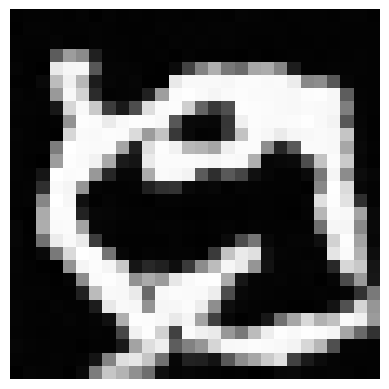

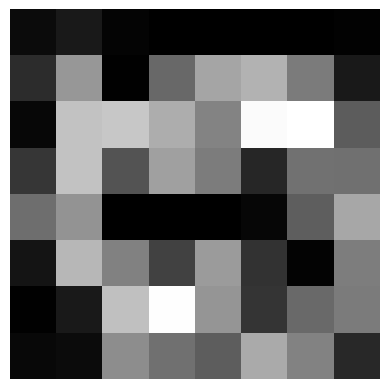

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the image using PIL
image_path = "/kaggle/working/default/samples3/x0_0_99.png"
image = Image.open(image_path)

# Print the size of the image
print("Image size:", image.size)  # Output format: (width, height)
plt.imshow(image, cmap='gray')  # Use 'cmap="gray"' if the image is grayscale
plt.axis('off')  # Hide axis labels
plt.show()

image_resized = image.resize((8, 8), Image.LANCZOS)

# If needed, convert it to a NumPy array
image_resized_array = np.array(image_resized)

plt.imshow(image_resized, cmap='gray')  # Use 'cmap="gray"' if the image is grayscale
plt.axis('off')  # Hide axis labels
plt.show()

In [ ]:
latent_size = 64
batch_size = 100
image_list=[]

from torch.autograd import Variable

for i in range(batch_size):
    image_path = f"/kaggle/working/default/samples3/x0_{i}_15.png"
    image = Image.open(image_path)
    
    image_resized = image.resize((8, 8), Image.LANCZOS)
    
    # If needed, convert it to a NumPy array
    image_array = np.array(image_resized).flatten()
    image_array = np.random.randint(0, 256, (8, 8)).flatten()

    image_list.append(image_array)

z = torch.from_numpy(np.array(image_list,dtype=np.float32)).cuda()
plt.imshow(z[0].cpu().detach().numpy().reshape(8,8), cmap='gray')  # Use 'cmap="gray"' if the image is grayscale
plt.axis('off')  # Hide axis labels
plt.show()
print(z.dtype)
z = Variable(z)
fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
# plt.imshow(fake_images_np[5].reshape(28,28), cmap='gray')  # Use 'cmap="gray"' if the image is grayscale
# plt.axis('off')  # Hide axis labels
# plt.show()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)

R, C = 10, 10
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

torch.Size([100, 64])


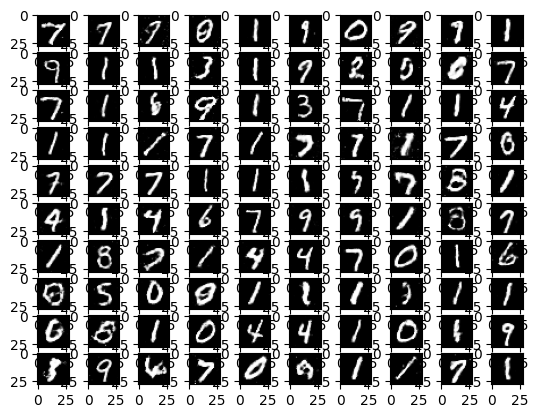

In [1]:
latent_size = 64
batch_size = 100

z = torch.randn(batch_size, latent_size).cuda()
print(z.shape)
z = Variable(z)
fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)

R, C = 10, 10
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

In [ ]:
!zip -r output.zip ./


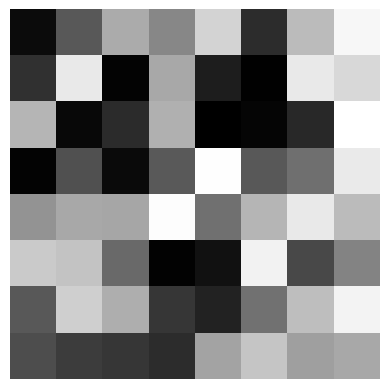

z dtype: torch.float32
z shape: torch.Size([100, 64])


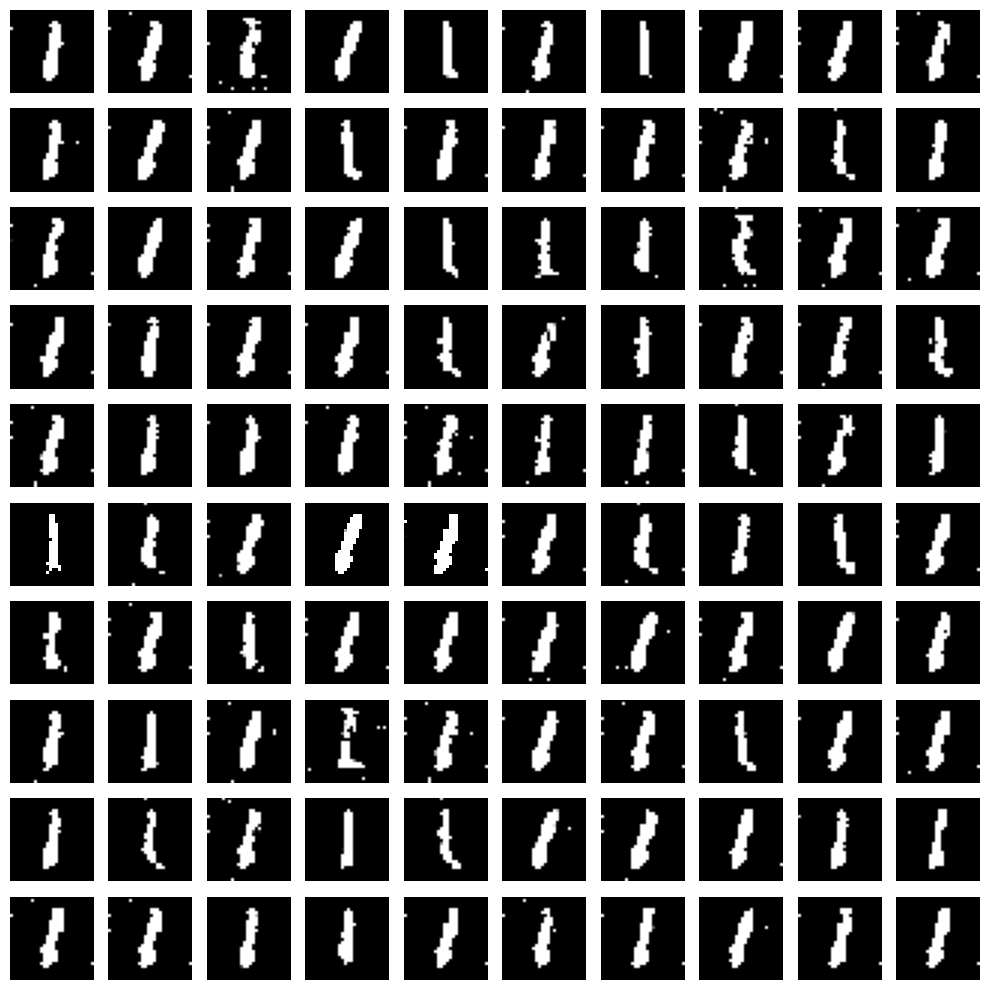

In [11]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

latent_size = 64
batch_size = 100
image_list = []

# Create random noisy images
for i in range(batch_size):
    # Generate a random noisy image (values between 0 and 255 for an 8x8 image)
    image_array = np.random.randint(0, 256, (8, 8)).flatten()
    image_list.append(image_array)

# Convert the list of noisy images to a tensor and normalize it
z = torch.from_numpy(np.array(image_list, dtype=np.float32))  # Normalized to 0-1

# Check if CUDA is available; otherwise, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z = z.to(device)

# Visualize the first noisy image
plt.imshow(z[0].cpu().detach().numpy().reshape(8, 8), cmap='gray')
plt.axis('off')  # Hide axis labels
plt.show()

# Check the dtype and shape
print("z dtype:", z.dtype)
print("z shape:", z.shape)

# Convert tensor to Variable
z = Variable(z)

# Ensure z is reshaped or transformed according to G's expected input shape, e.g., z should match (batch_size, latent_size) if G expects this.
if z.shape[1] != latent_size:
    z = z.view(batch_size, latent_size)

# Generate fake images using the generator G
fake_images = G(z)

# Convert the generated images to a numpy array
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)

# Display the generated images in a grid
R, C = 10, 10
plt.figure(figsize=(10, 10))
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
    plt.axis('off')  # Hide axis labels

plt.tight_layout()
plt.show()


In [3]:
!zip -r myOut.zip ./default

  adding: default/ (stored 0%)
  adding: default/ddpm_ckpt.pth (deflated 8%)
  adding: default/samples2/ (stored 0%)
  adding: default/samples2/x0_13.png (deflated 6%)
  adding: default/samples2/x0_26.png (deflated 8%)
  adding: default/samples2/x0_9.png (deflated 5%)
  adding: default/samples2/x0_22.png (deflated 8%)
  adding: default/samples2/x0_32.png (deflated 9%)
  adding: default/samples2/x0_97.png (deflated 7%)
  adding: default/samples2/x0_48.png (deflated 9%)
  adding: default/samples2/x0_5.png (deflated 5%)
  adding: default/samples2/x0_68.png (deflated 9%)
  adding: default/samples2/x0_40.png (deflated 9%)
  adding: default/samples2/x0_12.png (deflated 6%)
  adding: default/samples2/x0_3.png (deflated 5%)
  adding: default/samples2/x0_66.png (deflated 8%)
  adding: default/samples2/x0_41.png (deflated 9%)
  adding: default/samples2/x0_15.png (deflated 6%)
  adding: default/samples2/x0_61.png (deflated 9%)
  adding: default/samples2/x0_1.png (deflated 5%)
  adding: default/sa